forked from: https://www.kaggle.com/apapiu/regularized-linear-models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# 利用pd.DataFrame().col 可以像numpy一样索引，现在是将train和test的除SalePrice（预测目标）其余的内容结合
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

处理流程：
 - 用log函数将一些特征化曲为直
 - 对于标签类型的特征复制变量
 - 用平均值代替一些缺失值

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f621d44d780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f621d8f6208>]], dtype=object)

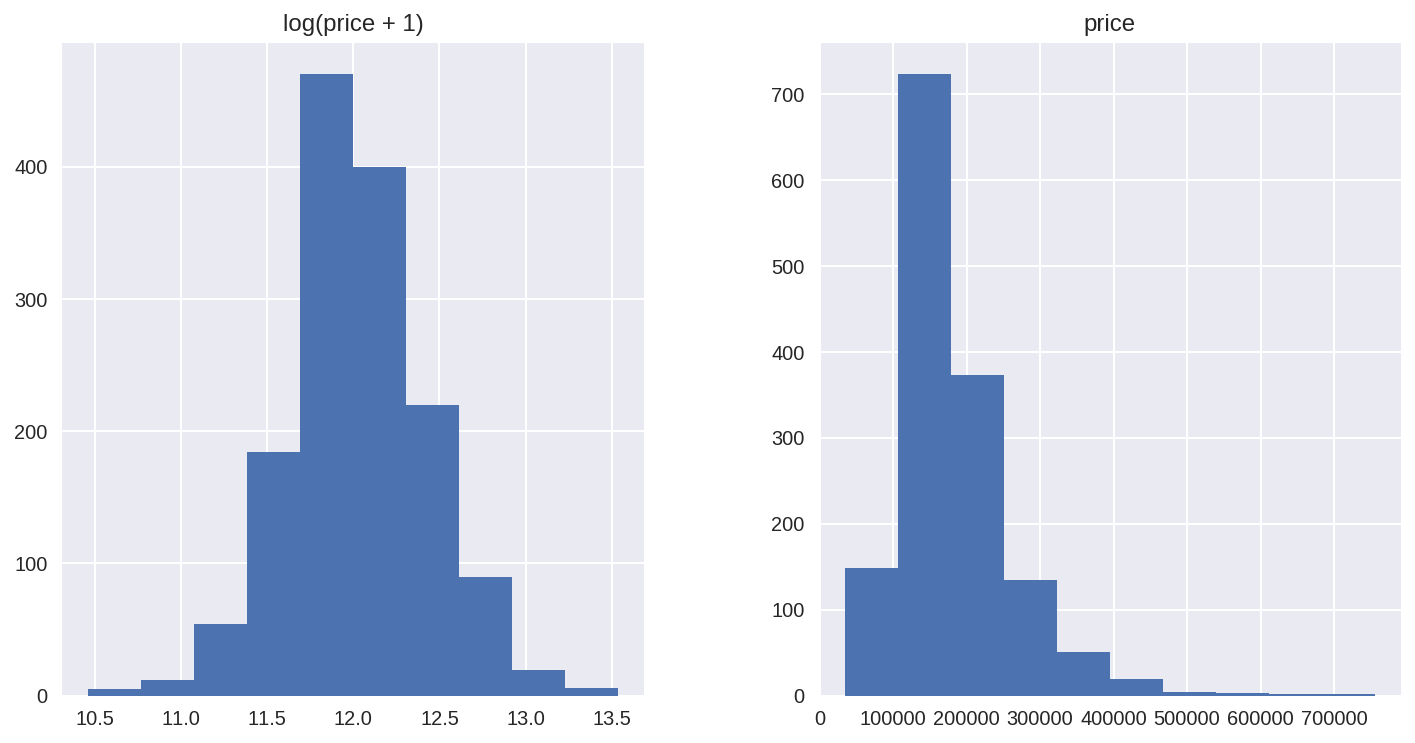

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
# 创建一个新的图表，其中第一列price为原来数据需要预测的SalePrice，另一列为它+1的log
prices.hist()
# 直接用hist可以plot出结果

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# 收集数值型变量的列（object是string类似的数据）
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print(numeric_feats)

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# 计算skew，匿名函数直接将x转化为skew(x)
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
# 得到偏度大于0.75的列的名称，然后将其结果用+1再log的方式代替
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [7]:
all_data = pd.get_dummies(all_data)
# dummies直接进行ont-hot编码，对每一个标签值都会进行onehot，得到非常长的稀疏矩阵,
# 数据不能过大否则容易MemoryError
print(all_data)

      MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0       4.110874     4.189655   9.042040            7            5       2003   
1       3.044522     4.394449   9.169623            6            8       1976   
2       4.110874     4.234107   9.328212            7            5       2001   
3       4.262680     4.110874   9.164401            7            5       1915   
4       4.110874     4.442651   9.565284            8            5       2000   
5       3.931826     4.454347   9.555064            5            5       1993   
6       3.044522     4.330733   9.218804            8            5       2004   
7       4.110874          NaN   9.247925            7            6       1973   
8       3.931826     3.951244   8.719481            7            5       1931   
9       5.252273     3.931826   8.912069            5            6       1939   
10      3.044522     4.262680   9.323758            5            5       1965   
11      4.110874     4.45434

In [8]:
# 按照列的平均值fill NaN空缺值
all_data = all_data.fillna(all_data.mean())

In [9]:
# 将结合了的数据再次分开成为X数据
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

用正则化的模型进行训练，同时自己新建一个平方差公式用于验证模型

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
# RMSE是均方根误差，这里采用了交叉验证（cross_val_score）
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
# "岭回归分类"模型
model_ridge = Ridge()

Ridge模型最主要的调整参数是alpha，一个正则化的参数，用于衡量模型的灵活性。正则化程度越高，模型越难以产生过拟合，但是较高的正则化程度也会使模型失去灵活性，并且不能够覆盖到所有的数据。

In [12]:
# 选择一系列alpha参数用于调参
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# 同时得到上面的模型的结果score的平均值
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

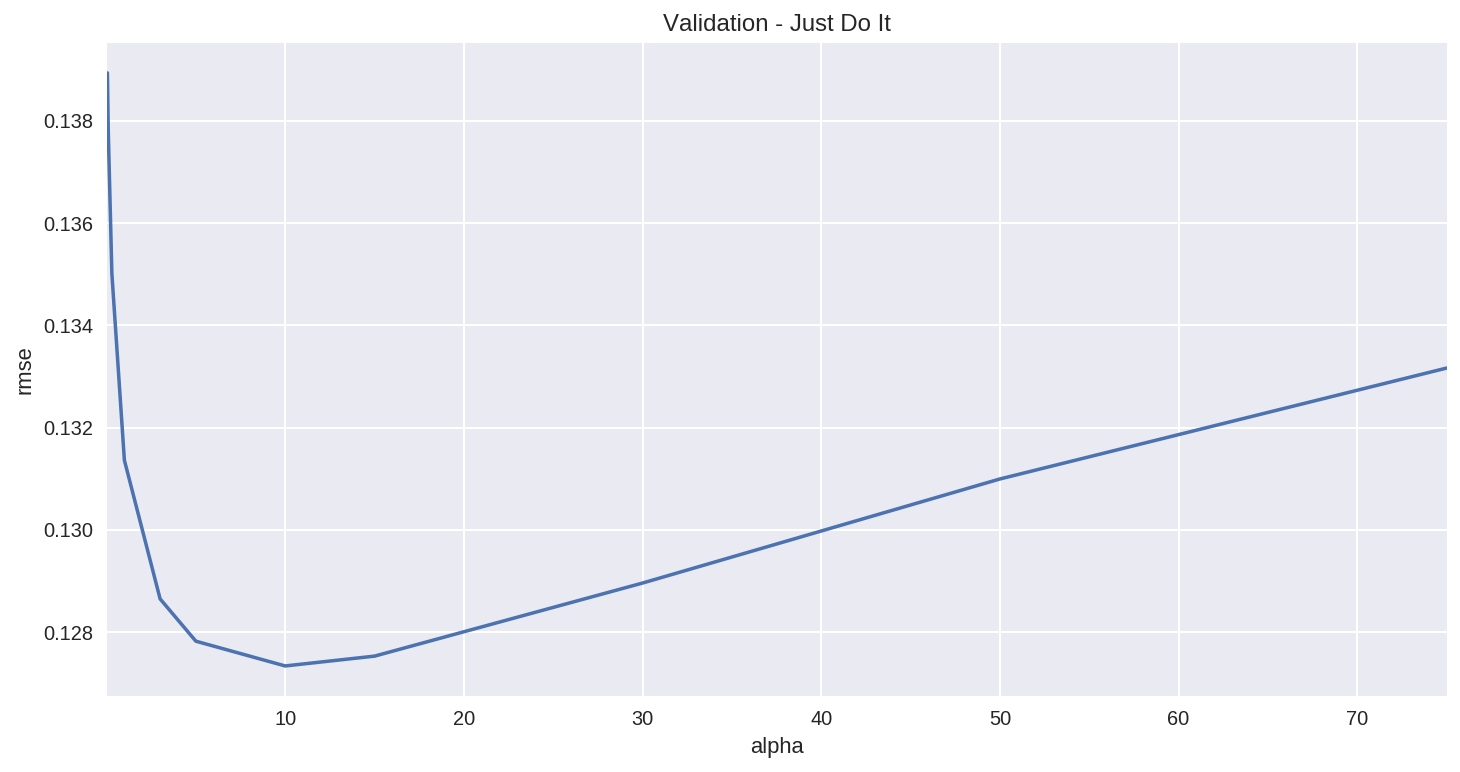

In [13]:
# 根据alpha参数和最终得到的score作图
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

如果alpha过大，正则化过强导致模型不能够cover所有的复杂性。如果灵活性过强即alpha较小，则模型开始过拟合，根据曲线，10是比较好的选择

In [14]:
cv_ridge.min()

0.12733734668670751

采用另一种Lasso CV模型，用于寻找最合适的alpha值，Lasso CV中的alpha值像是Ridge中的alpha或者它的反转。

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [16]:
rmse_cv(model_lasso).mean()

0.12314421090977427

Lasso模型更加，可以采用这个来预测，Lasso模型同时还能够直接进行特征选择，将其认为不重要的特征的系数设置为0，让我们看一下Lasso的结果

In [17]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Lasso排除了其他178个变量，选择了110个作为主要的变量，需要注意lasso选择出的不总是“正确”的特征。一个方法是在不同的样本中运行Lasso来观察选择出的变量是否稳定。

In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

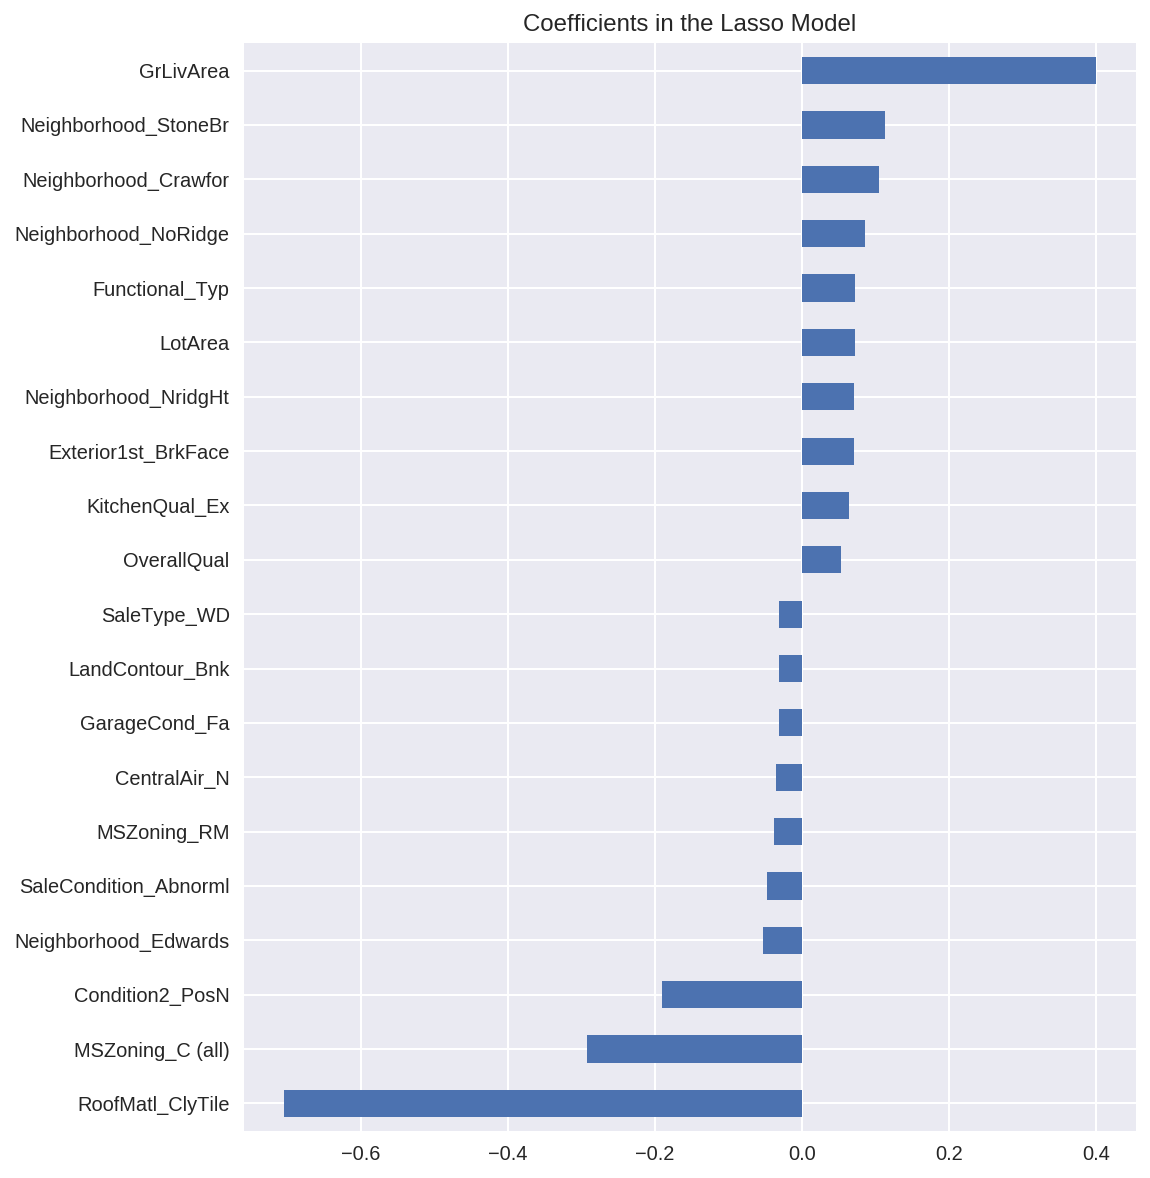

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
# 可以直接看到Lasso模型选择出的特征，比较符合现实

较多指标是“make sense”的。

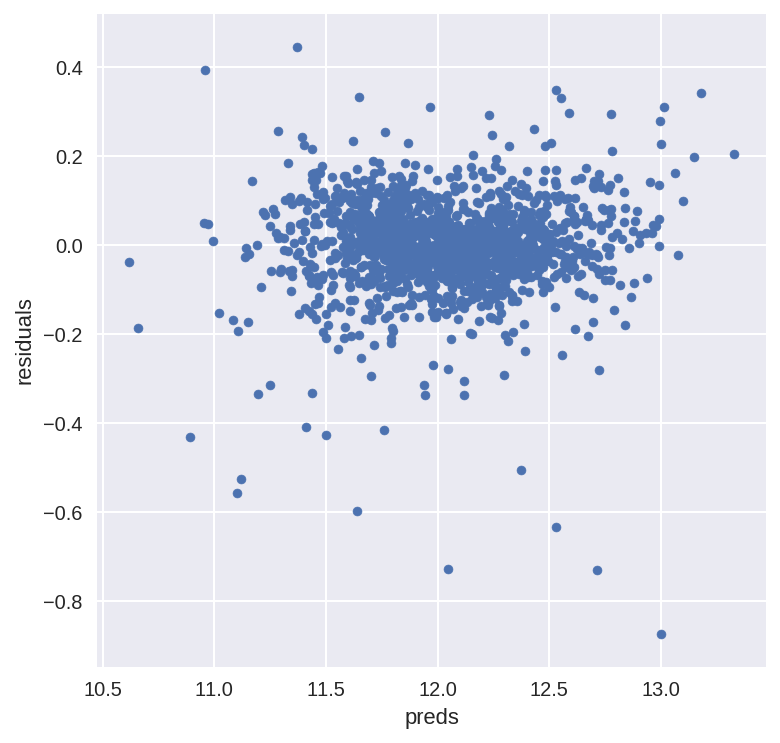

In [21]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
# 绘制剩余误差
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### 增加一个 xgboost 模型

Let's add an xgboost model to our linear model to see if we can improve our score:

In [22]:
import xgboost as xgb

In [23]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

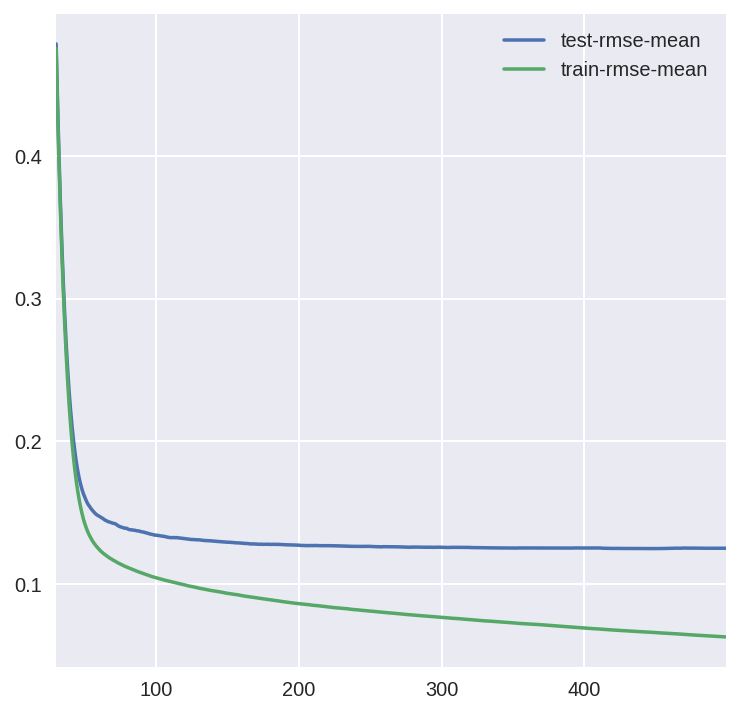

In [24]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

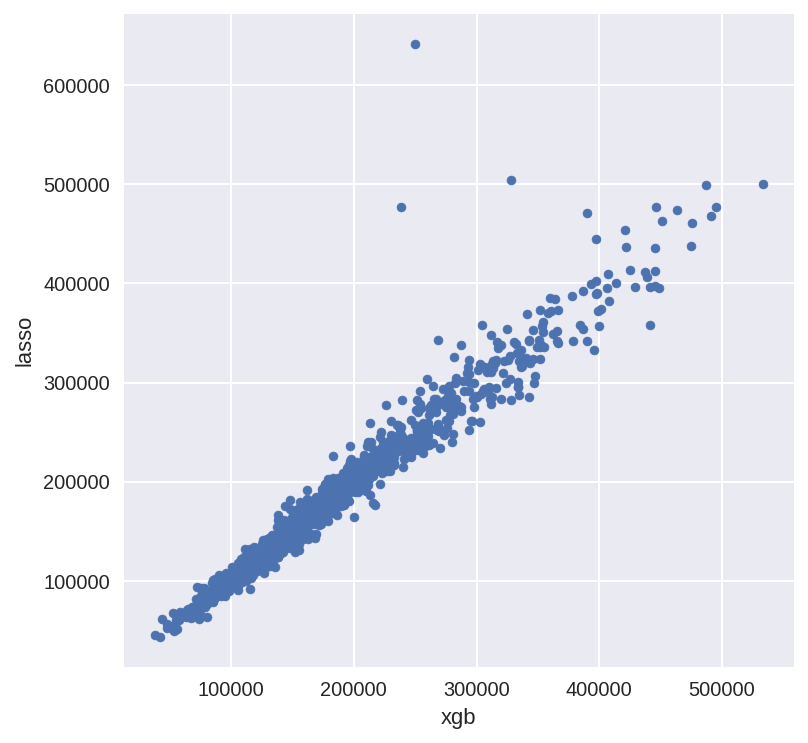

In [27]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [28]:
# 用两个模型按照比例组合得到回归结果
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [29]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [30]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [31]:
X_train = StandardScaler().fit_transform(X_train)

In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [33]:
X_tr.shape

(1095, 288)

In [34]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [35]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
model.summary()
# 没有隐藏层直接输出，也相当于回归，但是比起我之前做的一些数据分析，
# 这个回归中标签数量少，可以直接ont-hot，所以能够用神经网络

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [37]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
  32/1095 [..............................] - ETA: 1s - loss: 152.9958

 896/1095 [=======================>......] - ETA: 0s - loss: 146.9546

1095/1095 [==============================] - 0s - loss: 147.0507 - val_loss: 149.9412


Epoch 2/10
  32/1095 [..............................] - ETA: 0s - loss: 149.9856

 928/1095 [========================>.....] - ETA: 0s - loss: 144.5779

1095/1095 [==============================] - 0s - loss: 144.6449 - val_loss: 150.5451


Epoch 3/10
  32/1095 [..............................] - ETA: 0s - loss: 141.1355

 896/1095 [=======================>......] - ETA: 0s - loss: 142.6994

1095/1095 [==============================] - 0s - loss: 142.8837 - val_loss: 151.4042


Epoch 4/10
  32/1095 [..............................] - ETA: 0s - loss: 140.0323

 928/1095 [========================>.....] - ETA: 0s - loss: 141.8026

1095/1095 [==============================] - 0s - loss: 141.3165 - val_loss: 152.4388


Epoch 5/10
  32/1095 [..............................] - ETA: 0s - loss: 146.3186

 896/1095 [=======================>......] - ETA: 0s - loss: 140.6792

1095/1095 [==============================] - 0s - loss: 139.8916 - val_loss: 153.7210


Epoch 6/10
  32/1095 [..............................] - ETA: 0s - loss: 136.5096

 896/1095 [=======================>......] - ETA: 0s - loss: 138.6232

1095/1095 [==============================] - 0s - loss: 138.4848 - val_loss: 155.0224


Epoch 7/10
  32/1095 [..............................] - ETA: 0s - loss: 129.6937

 960/1095 [=========================>....] - ETA: 0s - loss: 136.9749

1095/1095 [==============================] - 0s - loss: 137.1873 - val_loss: 156.3708


Epoch 8/10
  32/1095 [..............................] - ETA: 0s - loss: 136.5629

 576/1095 [==============>...............] - ETA: 0s - loss: 135.5870

1095/1095 [==============================] - 0s - loss: 135.9122 - val_loss: 157.8411


Epoch 9/10
  32/1095 [..............................] - ETA: 0s - loss: 139.6367

1095/1095 [==============================] - 0s - loss: 134.6380 - val_loss: 159.4440


Epoch 10/10
  32/1095 [..............................] - ETA: 0s - loss: 134.4660

1088/1095 [============================>.] - ETA: 0s - loss: 133.2373

1095/1095 [==============================] - 0s - loss: 133.3399 - val_loss: 161.2572

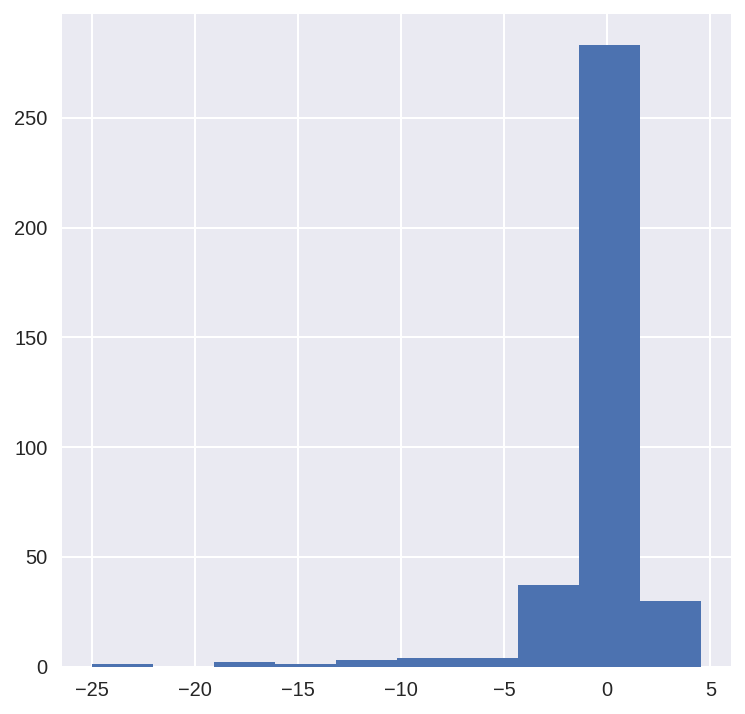

In [38]:
pd.Series(model.predict(X_val)[:,0]).hist()